In [4]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON
using Gurobi
using PiecewiseLinearOpt
using VegaLite, VegaDatasets
using FileIO

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [10]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 3 entries:
  "BARON"              => v"0.6.5"
  "PiecewiseLinearOpt" => v"0.3.0"
  "CPLEX"              => v"0.7.8"

In [59]:
innovations = CSV.File("./data-case-roadmap/innovation-user.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise.csv",header=1,delim=",") |> DataFrame
compromise[67:240,:GHG_ElecInd].+=1
compromise[100:165,:GHG_ElecInd].+=0.5
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations[3,2]=156
#innovations[2,6]=7
#compromise[!,3]=compromise[!,3]/2
#innovations[2,2]=175
#innovations[2,2]=205
#innovations[2,3]=2
#innovations[1,3]=3
#innovations[4,2]=108

#innovations[1,2]=185
#innovations[3,3]=2


innovations
innovations[9,3:ncol(inn_template)]=innovations[10,3:ncol(inn_template)]
#CSV.write("innovations.csv",innovations)

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,100,3,5.48,7.62,3.34,5.05,1.1,0
2,2,100,3,8.32,8.84,0.65,9.9,9.65,0
3,3,100,1,4.6,1.34,2.04,0.12,8.86,0
4,4,100,1,5.48,7.62,3.34,5.05,1.1,0
5,5,100,3,9.94,2.38,7.94,3.82,5.44,0
6,6,100,2,4.44,1.21,5.09,6.52,8.67,0
7,7,100,3,4.44,1.21,5.09,6.52,8.67,0
8,8,100,1,4.6,1.34,2.04,0.12,8.86,0
9,9,100,2,5.48,7.62,3.34,5.05,1.1,0


In [60]:
innovations[:,:name]

10-element Vector{String31}:
 "MSW pyrolysis to small olefins"
 "Source Segregation"
 "AI robot segregation"
 "LABS from PE"
 "Pyrolysis of LDPE"
 "Pyrolysis of HDPE"
 "Pyrolysis of PP"
 "Recycling back to PLA usin Clay"
 "Alkaline hydrolysis of PLA"
 "Alcoholysis of PLA"

In [61]:

compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [62]:
mapki[10,2]=240
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,29,MSW pyrolysis to small olefins
2,2,52,Source Segregation
3,3,66,AI robot segregation
4,4,91,LABS from PE
5,5,113,Pyrolysis of LDPE
6,6,140,Pyrolysis of HDPE
7,7,165,Pyrolysis of PP
8,8,193,Recycling back to PLA usin Clay
9,9,215,Alkaline hydrolysis of PLA


In [63]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


give_sorted (generic function with 1 method)

In [64]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],digits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],digits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),digits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [65]:
inn_reg = CSV.File("./data-case-roadmap/inn_reg.csv",header=1,delim=",") |> DataFrame
inn_xrang = CSV.File("./data-case-roadmap/inn_xrang.csv",header=1,delim=",") |> DataFrame
inn_yrang = CSV.File("./data-case-roadmap/inn_yrang.csv",header=1,delim=",") |> DataFrame
inn_yrang[!,"Y0"]=-1*(innovations[!,"RL"].-5)
inn_yrang

,Column1,Y0,Y1,Y2,Y3,Y4,Y5
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,2,2.27859,2.84023,3.24855,3.7742,4.34531
2,2,2,1.83764,1.76236,2.00334,2.42641,3.01637
3,3,4,3.50466,3.44728,3.96065,4.98697,6.3803
4,4,4,3.55034,3.28297,3.38488,3.83014,4.56971
5,5,2,2.01948,2.18758,2.53377,3.06663,3.74638
6,6,3,2.65052,2.57007,2.95754,3.74405,4.796
7,7,2,2.04706,2.66122,3.34143,4.007,4.80312
8,8,4,3.50466,3.44728,3.96065,4.98697,6.3803
9,9,3,3.17394,3.35651,3.64222,4.03856,4.55208


In [66]:
tau=[0,5,10,15,20,25,30]

7-element Vector{Int64}:
  0
  5
 10
 15
 20
 25
 30

In [67]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [68]:
initial

,k,i,GWP,Theta,Per_Recycl,Per_Comp,Ocost
,Int64,Int64,Int64,Float64,Float64,Int64,Float64
1,0,0,8,0.15,0.12,0,3.2


In [73]:
function tech_roadmap_mccormick_peicewise_iam_multipd(co2_target,circularity_target)
    
    rdmap= Model(Gurobi.Optimizer)
    #rdmap=Model(BARON.Optimizer)
    #set_optimizer_attribute(rdmap, "MaxTime", 250)
    #set_optimizer_attribute(rdmap, "DoLocal", 0)
    #set_optimizer_attribute(rdmap, "NumLoc", 0)
    set_optimizer_attribute(rdmap, "NonConvex", 2)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise),tt=1:7],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise),tt=1:7] ≤ 5)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise),tt=1:7] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations),tt=1:7],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations),tt=1:7] ≤ 5)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations),tt=1:7] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050[tt=1:7])
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030[tt=1:7] ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030[tt=1:7] ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030[tt=1:7] ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations),tt=1:7] ≥ 0)
    @variable(rdmap,co2_factor[k=1:nrow(compromise),tt=1:7]≥ 0)
    @variable(rdmap,co2_corrected[k=1:nrow(compromise),tt=1:7]≥ 0)

    for i in 1:nrow(innovations)
        for tt in 1:7
            f_fit[i,tt] = piecewiselinear(rdmap, tau[tt]+ti[i,tt], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
        end
    end
            
    
    for k in 1:nrow(compromise)
        for tt in 1:7
            co2_factor[k,tt] = (piecewiselinear(rdmap, tau[tt]+tk[k,tt], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:2])[:,1]))
    
        end
    end
    
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
        compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(co2_factor[k,tt])))
    
    #Constraints
    
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1,tt=1:7], sum(yk[k,tt] for k=1:mapki[i,2])≤ yi[i,tt])
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], sum(yk[k,tt] for k=mapki[i-1,2]:mapki[i,2])≤ yi[i,tt])
    #@constraint(rdmap,[k=2:nrow(compromise),tt=1:7],tk[k-1,tt]==tk[k,tt])
    
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1,tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:7], 5*yi[i,tt] ≥ ti[i,tt])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], 5*yk[k,tt] ≥ tk[k,tt])
    
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:6], yi[i,tt+1] ≥ yi[i,tt])
    @constraint(rdmap, [i=1:nrow(mapki),tt=2:7],ti[i,tt]≤ 5*( yi[i,tt]-yi[i,tt-1]))
    
    #if compromise chosen across boundary tk=0
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5*( yk[k,tt]-yk[k,tt-1]))
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5000*( xk[k,tt]-xk[k,tt-1]))
    #time of change has to be same
    #=   
    @variables(rdmap,begin 
                    u1[k=1:nrow(compromise),tt=2:7], Bin
                    u2[k=1:nrow(compromise),tt=2:7], Bin
                    u0[k=1:nrow(compromise),tt=2:7], Bin
        end)
    
    
    for i in 2:nrow(mapki)
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    end
    
    i=1
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])  
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    =#  
    
    
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], yk[k,tt] ≥ xk[k,tt])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1i
    @constraint(rdmap,[tt=1:7], sum(xk[k,tt] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    #@constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
    #    + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3])
    
    @constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
        + (initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5))
    
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:6], xk[k,tt+1] ≥ xk[k,tt])
    
    #tk < 30
    #@variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-40)
    
    #circularity at 2030 target
    #@constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
    #   + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap,[tt=3:7], recycl_2030[tt]==sum(xk[k,tt]*compromise[k,5] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap,[tt=3:7], comp_2030[tt]==sum(xk[k,tt]*compromise[k,6] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ w1k[k=1:nrow(compromise),tt=2:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≥ 5*xk[k,tt-1]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ 5*xk[k,tt-1])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ tk[k,tt])
    
    @variable(rdmap,0 ≤ w2k[k=1:nrow(compromise),tt=1:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≥ 5*xk[k,tt]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ 5*xk[k,tt])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ tk[k,tt])
    
    
    
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5-tk[k,tt])*xk[k,tt]*
    #                        (initial[1,3]-co2_corrected[k,tt]) for k in 1:nrow(compromise)) for tt in 1:6))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5*xk[k,tt]-wk[k,tt])*(initial[1,3]-co2_corrected[k,tt]) 
    #                for k in 1:nrow(compromise)) for tt in 1:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                    -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])+(w2k[k,tt]*co2_corrected[k,tt])
    #                    + 5*initial[1,3]*(sum(xk[k,tt-1] for k in 1:nrow(compromise))-sum(xk[k,tt] for k in 1:nrow(compromise)))
    #                    for k in 1:nrow(compromise)) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])-(w2k[k,tt]*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) - 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) + 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
     
    
    #correct one
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(w1k[k,tt]-(w2k[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    @constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
                    +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
                    for k in 1:nrow(compromise)) for tt in 2:7) + 
                    sum(5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    @variable(rdmap,comp[tt=2:7])
    @constraint(rdmap,[tt=2:7],comp[tt]==sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5)
        
    #@constraint(rdmap, 120*0.001*co2_tot ≤ 360)
    

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050[7] .≤ co2_target)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    @constraint(rdmap,[tt=3:7], recycl_2030[tt] + comp_2030[tt] ≥ circularity_target)
    
    #setting target for 2030 comp pledge
    #@constraint(rdmap, comp_2030 ≥ 0.45)
    
    #@constraint(rdmap,[k=1:25,tt=3:7],tk[k,tt]==0)


    #investment cost
    @constraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
                for i in 1:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
    
    #operating cost
    @variable(rdmap,cost_op ≥ 0)
    @constraint(rdmap,cost_op == sum(sum(xk[k,tt]*compromise[k,9]*0.968^(-1*tau[tt]) for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,7]*0.968^(-1*tau[tt]) for tt in 1:7))

    
    @constraint(rdmap, [i=1:nrow(innovations),tt=1:7],s[i,tt]==f_fit[i,tt])
    
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    #@constraint(rdmap,[i=1:nrow(innovations)],sum(yi[i,tt] for tt=1:7)≥1)
    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    #120*0.001*co2_tot+
    @objective(rdmap,Min,120*0.001*co2_tot+cost_inn+cost_op)
    #120*0.001*co2_tot+
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(co2_corrected), JuMP.value.(co2_factor), JuMP.values.(comp)
end




tech_roadmap_mccormick_peicewise_iam_multipd (generic function with 1 method)

In [74]:
yk, tk, xk, yi, ti, s, co2, costInn, co2tot, co2fac, cc, comp1=tech_roadmap_mccormick_peicewise_iam_multipd(0.4,0.75)
yi


Academic license - for non-commercial use only - expires 2022-11-07
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 30574 rows, 29337 columns and 109143 nonzeros
Model fingerprint: 0x368f34e7
Model has 10 quadratic constraints
Variable types: 22337 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+01]
  QMatrix range    [2e-01, 1e+02]
  QLMatrix range   [1e+00, 4e+01]
  Objective range  [1e-01, 1e+00]
  Bounds range     [3e-01, 6e+00]
  RHS range        [1e-01, 4e+01]
  QRHS range       [1e+04, 1e+04]
Presolve removed 10514 rows and 13668 columns
Presolve time: 0.21s
Presolved: 49260 rows, 22999 columns, 185693 nonzeros
Presolved model has 7200 bilinear constraint(s)
Variable types: 19536 continuous, 3463 integer (3463 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only.

10×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

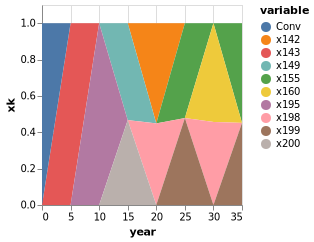

In [76]:

transpose(xk)
df1=DataFrame(xk',:auto)
df1[!,:year] = 5*collect(1:7)
df1=df1[!, any.(>(0), eachcol(df1))]
df1[!,:Conv] = zeros(7)
sNames="compromise ".*string.(collect(1:length(xk[:,1])))
push!(df1,zeros(size(df1)[2]))
df1[8,:Conv]=1

comp=df1 |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="xk"}, color="variable:n",legend=:sNames) 
#save("./result-case-roadmap/compromise-roadmap.svg", comp)
comp


In [15]:
tk

240×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
JuMP.value.(comp1)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 2:7
And data, a 6-element Vector{Float64}:
  5.321118545786874e-12
  1.974078886468611e-12
  1.8834066251027792e-12
  1.763224982687106e-12
  1.2720954537865731e-12
 -1.2292518239703093e-12

In [17]:
df1

,x93,x94,x103,x108,x195,x197,x198,x199,x200
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.531119,0.0,0.0,0.0,0.0,0.0,0.468881
4,0.551468,0.0,0.0,0.0,0.0,0.0,0.0,0.448532,0.0
5,0.0,0.0,0.0,0.548152,0.0,0.0,0.451848,0.0,0.0
6,0.551468,0.0,0.0,0.0,0.0,0.0,0.0,0.448532,0.0
7,0.0,0.0,0.0,0.662016,0.0,0.337984,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_tk=DataFrame(tk',:auto)
#CSV.write("./result-case-roadmap/tk", df_tk)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,29,MSW pyrolysis to small olefins
2,2,52,Source Segregation
3,3,66,AI robot segregation
4,4,91,LABS from PE
5,5,113,Pyrolysis of LDPE
6,6,140,Pyrolysis of HDPE
7,7,165,Pyrolysis of PP
8,8,193,Recycling back to PLA usin Clay
9,9,215,Alkaline hydrolysis of PLA


In [20]:
yi

10×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
rename!(df1,[:x92,:x103,:x217,:x221] .=> [:pyLDPE1,:pyLDPE11,:alcPLA2,:alcPLA6])
df0=DataFrame(year=0,Conv=1.0,pyLDPE1=0.0,pyLDPE11=0.0,alcPLA2=0.0,alcPLA6=0.0)
append!(df0,df1)
df0
comp=df0 |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="xk"}, color="variable:n",legend=:sNames) 
#save("./result-case-roadmap/compromise-roadmap.svg", comp)
comp

LoadError: ArgumentError: Tried renaming :x92 to :pyLDPE1, when :x92 does not exist in the data frame.

In [22]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,29,MSW pyrolysis to small olefins
2,2,52,Source Segregation
3,3,66,AI robot segregation
4,4,91,LABS from PE
5,5,113,Pyrolysis of LDPE
6,6,140,Pyrolysis of HDPE
7,7,165,Pyrolysis of PP
8,8,193,Recycling back to PLA usin Clay
9,9,215,Alkaline hydrolysis of PLA


In [23]:
xk

240×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [24]:
ti  

10×7 Matrix{Float64}:
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 5.99099e-11  0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0
 8.13841e-10  0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [26]:
s

10×7 Matrix{Float64}:
 2.0  1.93097  2.08861  2.24624  2.60288  2.95952  3.36712
 2.0  1.93097  2.08861  2.24624  2.60288  2.95952  3.36712
 4.0  3.69121  4.08332  4.47542  5.18264  5.99488  6.92121
 4.0  3.72014  3.89779  4.07544  4.47475  4.94796  5.49309
 2.0  2.15894  2.31787  2.62687  2.98589  3.44992  4.01899
 3.0  2.68846  2.96366  3.23887  3.76307  4.37027  5.05987
 2.0  2.25727  2.63287  3.12678  3.62069  4.32956  5.03843
 4.0  3.69121  4.08332  4.47542  5.18264  5.99488  6.92121
 3.0  3.29813  3.59627  3.8944   4.34283  4.79125  5.42961
 4.0  3.72014  3.89779  4.07544  4.47475  4.94796  5.49309

In [27]:
df1

,x93,x94,x103,x108,x195,x197,x198,x199,x200
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.531119,0.0,0.0,0.0,0.0,0.0,0.468881
4,0.551468,0.0,0.0,0.0,0.0,0.0,0.0,0.448532,0.0
5,0.0,0.0,0.0,0.548152,0.0,0.0,0.451848,0.0,0.0
6,0.551468,0.0,0.0,0.0,0.0,0.0,0.0,0.448532,0.0
7,0.0,0.0,0.0,0.662016,0.0,0.337984,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
iam_model

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


In [29]:
sum(xk[:,1])

1.0

In [30]:
mod(6,5)

1

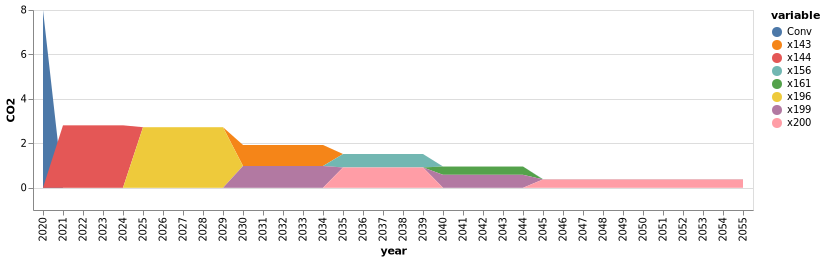

In [77]:
#only for this result

function conventional0(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round(JuMP.values.(tk)[k1,t+1];digits=2) for k1=1:nrow(compromise)),5)
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
end

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,3]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 6 ≤ t ≤ 10
        j=2
    elseif 11 ≤ t ≤ 15
        j=3
    elseif 16 ≤ t ≤ 20
        j=4
    elseif 21 ≤ t ≤ 25
        j=5
    else
        j=6
    end
    
    
    
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,3]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x1] .=> [:Conv])
#df[!,:x104]=zeros(36)
#df[!,:x201]=zeros(36)
#df[!,:x196]=zeros(36)
#df[!,:x126]=zeros(36)
#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/co2-roadmap-sc2.svg", co2_inn)
co2_inn



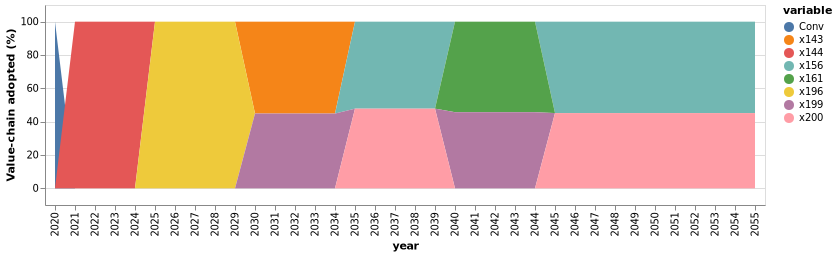

In [78]:
#only for this result

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)
    end
end

function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
end

conv=zeros(51)

conv[1]=100
inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 6 ≤ t ≤ 10
        j=2
    elseif 11 ≤ t ≤ 15
        j=3
    elseif 16 ≤ t ≤ 20
        j=4
    elseif 21 ≤ t ≤ 25
        j=5
    else
        j=6
    end
    
    
    
    conv[t]=100*conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=100*innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,3]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x1] .=> [:Conv])
#df[!,:x104]=zeros(36)
#df[!,:x201]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

split_yearly=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Value-chain adopted (%)"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/split_yearly-sc2.svg", split_yearly)
split_yearly



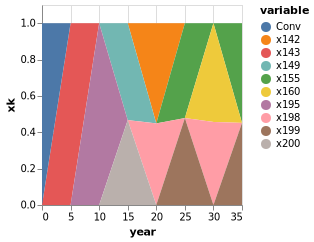

In [79]:
comp

In [80]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,29,MSW pyrolysis to small olefins
2,2,52,Source Segregation
3,3,66,AI robot segregation
4,4,91,LABS from PE
5,5,113,Pyrolysis of LDPE
6,6,140,Pyrolysis of HDPE
7,7,165,Pyrolysis of PP
8,8,193,Recycling back to PLA usin Clay
9,9,215,Alkaline hydrolysis of PLA


In [86]:
compromise[199,:]

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
199,199,9,3.4669,0.7436,0.661689,0.196905,1.58,0.132,1.6963


In [81]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(xk[i,:].*co2fac[i,:];digits=2))
    end
end

142[0.0, 0.0, 0.0, 0.95, 0.0, 0.0, 0.0]
143[2.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
149[0.0, 0.0, 1.64, 0.0, 0.0, 0.0, 0.0]
155[0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.01]
160[0.0, 0.0, 0.0, 0.0, 0.0, 0.37, 0.0]
195[0.0, 2.73, 0.0, 0.0, 0.0, 0.0, 0.0]
198[0.0, 0.0, 0.0, 0.98, 0.0, 0.58, 0.0]
199[0.0, 0.0, 0.0, 0.0, 0.91, 0.0, 0.38]
200[0.0, 0.0, 1.24, 0.0, 0.0, 0.0, 0.0]


In [82]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(xk[i,:];digits=2))
    end
end

142[0.0, 0.0, 0.0, 0.55, 0.0, 0.0, 0.0]
143[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
149[0.0, 0.0, 0.53, 0.0, 0.0, 0.0, 0.0]
155[0.0, 0.0, 0.0, 0.0, 0.52, 0.0, 0.55]
160[0.0, 0.0, 0.0, 0.0, 0.0, 0.54, 0.0]
195[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
198[0.0, 0.0, 0.0, 0.45, 0.0, 0.46, 0.0]
199[0.0, 0.0, 0.0, 0.0, 0.48, 0.0, 0.45]
200[0.0, 0.0, 0.47, 0.0, 0.0, 0.0, 0.0]


In [37]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(tk[i,:];digits=2))
    end
end

93[0.0, 0.0, 0.0, 5.0, 0.0, 5.0, 0.0]
94[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
103[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0]
108[0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 5.0]
195[5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0]
197[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0]
198[0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0]
199[0.0, 0.0, 0.0, 5.0, 0.0, 5.0, 0.0]
200[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0]


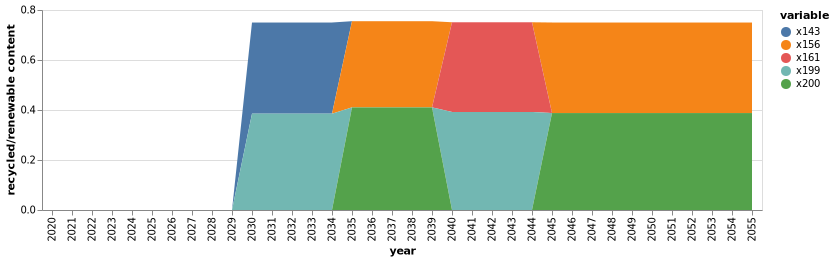

In [83]:
#=
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i1,k1,t)
     if mod(i1,5)>JuMP.values.(tk)[k1,t] && t<7
        t=t+1
    end
    if k1==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1)
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1 )
    end
end
=#

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,5]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(compromise[k,5]+compromise[k,6]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(compromise[k,5]+compromise[k,6]) for k=k1:k1)
end





conv=zeros(51)


inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 6 ≤ t ≤ 10
        j=2
    elseif 11 ≤ t ≤ 15
        j=3
    elseif 16 ≤ t ≤ 20
        j=4
    elseif 21 ≤ t ≤ 25
        j=5
    else
        j=6
    end
        
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,5]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x104,:x222] .=> [:Conv,:pyLDPE1,:pyLDPE11,:alcPLA6])
#df[!,:alcPLA2]=zeros(36)
#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 
#df[!,:Conv]=zeros(36)
#df[!,:x104]=zeros(36)
#df[!,:x196]=zeros(36)
#df[!,:x201]=zeros(36)
#df[!,:x95]=zeros(36)
#rename!(df,[:x1,:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:Conv,:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

#rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn


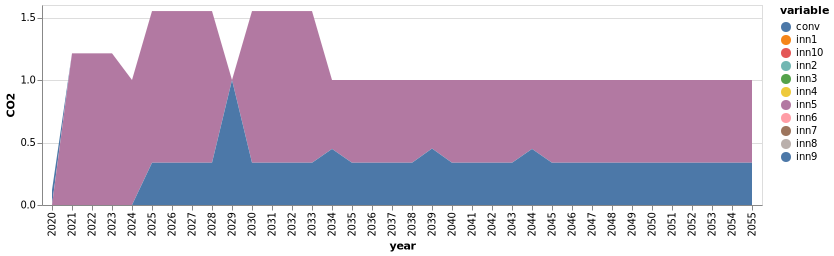

In [39]:
function conventional(t)
    return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i0,i,t)
    #if mod(i0,5)>JuMP.values.(tk)[k1,t] && t<7
    #    t=t+1
    #end
    if i==1
        s=0
        for k1 in 1:mapki[i,2]
            if mod(i0,5)>JuMP.values.(tk)[k1,t] && t<7
                t=t+1
            end
        s+=JuMP.values.(xk)[k1,t]
        end
        return s   
    else
        s=0
        for k1 in mapki[i-1,2]:mapki[i,2]
            if mod(i0,5)>JuMP.values.(tk)[k1,t] && t<7
                t=t+1
            end
        s+=JuMP.values.(xk)[k1,t]
        end
        return s   
        #return sum(JuMP.values.(xk)[k,t] for k=mapki[i-1,2]:mapki[i,2] )
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end

j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(i,inn,j)
    end
end

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]
df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

In [40]:
#=
#cost objective
#@NLconstraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
#            for i in 2:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
#linearization
@variable(rdmap,0≤p[i=1:nrow(innovations),tt=2:7]≤5)
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≤5*(yi[i,tt]-yi[i,tt-1]))
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≤(f_fit[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≥(f_fit[i,tt])-5*(1-(yi[i,tt]-yi[i,tt-1])))

@variable(rdmap,0≤q[i=1:nrow(innovations),tt=1:1]≤5)
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≤(yi[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≤(f_fit[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≥(f_fit[i,tt])-5*(1-(yi[i,tt])))

@constraint(rdmap,cost_inn == sum(sum(ci[i]*p[i,tt] for i in 2:nrow(innovations)) for tt in 2:7) +
                                sum(ci[i]*q[i,1] for i in 1:nrow(innovations)))

#http://yetanothermathprogrammingconsultant.blogspot.com/2008/05/multiplication-of-continuous-and-binary.html

=#


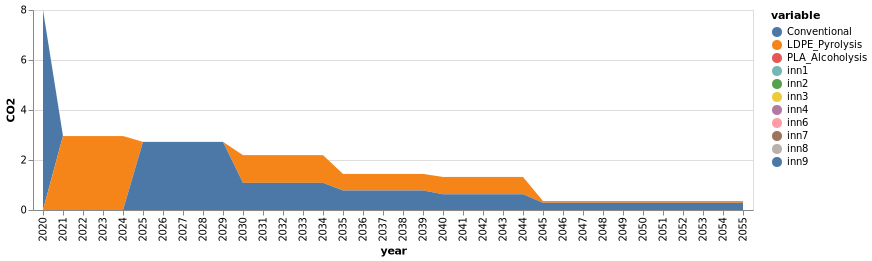

In [41]:
function conventional(t)
    return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=mapki[i-1,2]:mapki[i,2])
    end
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end
j=0
for i in 2:51
    
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
    
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end


sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]

rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/co2-roadmap.svg", co2_inn)
co2_inn



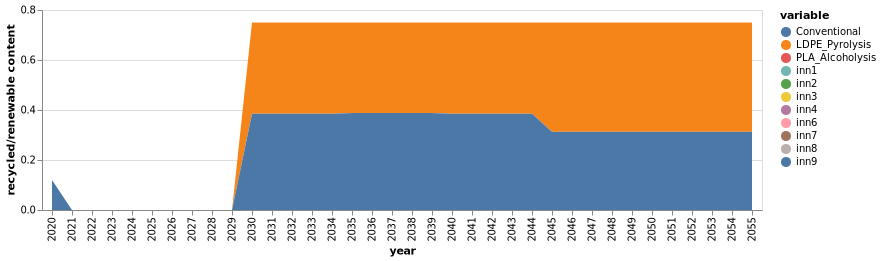

In [42]:
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=mapki[i-1,2]:mapki[i,2] )
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end

j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end
sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]


#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 


rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn
